# Project 2 TinyML

**TEAM K**

Chouliaras Andreas

Pappas Apostolos

Stylianos Gkountouvas

## What Is TinyML?


In recent years a completely new class of products has started to emerge, with the key characteristic that they use machine learning to **extract info of noisy sensor data**.

These devices consume **less than one milliwatt** of power and that enables them to run on battery for years.

One example of that is what the "OK Google" team is doing. Most Android smartphones, if not all, support waking the device by saying "OK Google". The voice recognition task **must run continuously**, but the main CPU of a smartphone most of the time is turned off to conserve power. The team designed neural networks that were just 14 kilobytes in size that **run on the digital signal processors** (DSPs) present on most Android phones which only use **a few milliwatts of power**.


This is were the TinyML idea comes from.

We can define **TinyML** as the process of using ultra-low power and very cheap devices to run ML algorithms to make sense of noisy sensor data.

## What is a ultra-low power and cheap device?

### Single-board Computers

When someone thinks of a **low power** and cheap computers, single-board computers (sbc) such as the Raspberry Pi or Nvidia Jetson comes to mind.

However, although these devices are fantastic for many uses, their **power consumption is similar or bigger than a smartphones CPU** and keeping one running for a couple of days requires a big battery.

This is usually not a problem for their use cases because they have a large power source for themselves and the lack of resource constraints means that frameworks like TensorFlow, TensorFlow Lite, and Nvidia’s TensorRT are available for them, but that means we cant use them for TinyML.

Another characteristic we want about our devices is **low cost**.

The cheapest Raspberry Pi Zero is about 5€ and all other sbcs cost is way higher. In contrast microcontrollers can cost lower than 1€.

### Microcontrollers and Embedded devices

By defining TinyML as being below one milliwatt does mean that we have to look to **the world of embedded devices** for our hardware platforms.

Traditionally they had been eight-bit devices and used obscure and proprietary toolchains, so it seemed very intimidating to get started with any of them. A big step forward came when Arduino introduced a user-friendly IDE along with standardized hardware, and since then 32-bit MCUs (microcontroller units) have become the standard.

Even though the development process has got easier, **embedded devices have very constrained resources**.

Most of them have only a few hundred kilobytes of RAM, similar amounts of persistent flash memory and the clock speed is just tens of megahertz.

In addition most of them do can not run an operating system and if one can then it will not provide any of the POSIX or standard C library functions you expect. Many MCUs do not support dynamic memory allocation and using a debugger may be tricky and that makes programming them for challenging.

**Comparisson of different MCUs and SBCs**


| Board         | Arduino Nano | Arduino Mega  | Teensy LC  | ESP8266        | Teensy 4.0 | Raspberry Pi Zero | Raspberry Pi 4|
| --------------|------------- | ------------- | ---------- | -------------- | ---------- | ----------------- | ------------- |
| Processor/MCU | ATmega328    | ATmega2560    | Cortex-M0+ | Xtensa l106    | Cortex-M7  | BCM2835           | BCM2711       |
| Architecture  | 8-bit AVR    | 8-bit AVR     | 32-bit ARM | 32-bit Harvard | 32-bit ARM | 32-bit ARM        | 32-bit ARM    |
| Clock         | 16 MHz       | 16 MHz        | 48 MHz     | 80 MHz         | 600 MHz    | 1 GHz             | 4x1.5 GHz     |
| RAM           | 2 KB         | 8 KB          | 8 KB       | 64 KB          | 1024K KB   | 512 MB            | 1-4 GB        |
| Flash         | 32 KB        | 256 KB        | 62 KB      | 4096 KB        | 2018 KB    | SD Card           | SD Card       |
|Power Consumption*| 50 mWatt  | 50 mWatt      | 100 mWatt  | 165 mWatt      | 400 mWatt  | 1 Watt            | 6.25 Watt     |
| Cost**        | <1 €         | >5 €          | <1 €       | <2 €           | >3,5 €     | 5 €               | 40 €          |


\* Power consumption when running, most MCUs can reach < 1mWatt when in sleep mode

\** Cost of only the Processor/MCU when applicable

![arduino_uno](./images/arduino_uno.png)


## Machine Learning Recap

Machine learning is a technique for using computers to predict things based on past observations.

We collect data, then we create a computer program that analyzes that data and uses it to predict future states.

There are many different approaches to machine learning with the most popular being called **deep learning**.

In deep learning, a network of simulated neurons is trained to model the relationships between various inputs and outputs. Different architectures, or arrangements of simulated neurons, are useful for different tasks, like extracting meaning from image data or predicting the next value in a sequence.

It may be surprising to discover that deep learning can work even on devices with limited memory and processing power such as microcontrollers, and we will learn how we can create deep learning models that do some interesting things but still fit within the constraints of these devices.

![dnn_ch3](./images/dnn_ch3.png)

## TensorFlow Lite for Microcontrollers

The software we will be using to make ML applications for MCUs is called **TensorFlow Lite**

### What is TensorFlow Lite for Microcontrollers?

The first question you might ask is what does the framework actually do? 

To understand that, it helps to break the  name down a bit and explain the components.

**TensorFlow**

[TensorFlow](https://tensorflow.org) is Google’s open source machine learning library.

When TensorFlow was launched the ability to train models and run models in desktop environments was needed and this influenced many decision choices due to the vast amount of resources modern computers have.

However using TensorFlow for other platforms, like smartphones, was a bit problematic due to the **huge increase in the size of the app**.

**TensorFlow Lite**

To meet these lower size requirements for mobile platforms, in 2017 Google started a companion project to mainline TensorFlow called **TensorFlow Lite**.

This library is aimed at running neural network models efficiently and easily on mobile devices and to achieve this some less common features must be droped.

For example it **doesn’t support training**, just running inference on models that were previously trained, some data types are not supported (doubles) and some less-used operations aren’t present.


**TensorFlow Lite for Microcontrollers**

However TensorFlow Lite was still not enough for many applications built on embedded platforms because it **could not fit on them**.

In embedded environments even **a few hundred kilobytes is too large** and many dependencies we take for granted, like the **C Standard Library, is not present**.

So with those restrictions in mind in 2018 a team at Google started experimenting with a specialized version of TensorFlow Lite aimed just at these embedded platforms.

## TinyML: Building and Training a Model

To create our simple machine learning model, we’ll be using Python and TensorFlow.

In this simple example the data we’ll be training with is a sine wave.

![sine_wave_ch4](./images/sine_wave_ch4.png)

The first step is to create a model that can take a value, x, and predict its sine, y.

The second step is to to run this model on a hardware device.

Although this is not really usefull it is simple and will help demonstrate the basic principles we need to know.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import os

### Generating Data

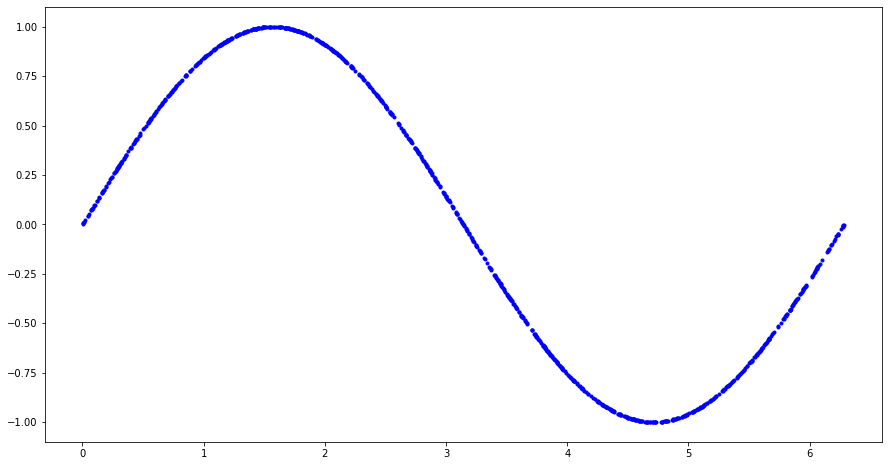

In [2]:
# We'll generate this many sample datapoints
SAMPLES = 1000
SEED = 420
np.random.seed(SEED)
tf.random.set_seed(SEED)

x_values = np.random.uniform(low=0, high=2*math.pi, size=SAMPLES)
np.random.shuffle(x_values)

y_values = np.sin(x_values)


fig, axes = plt.subplots(figsize=(15,8))
axes.plot(x_values, y_values, 'b.')

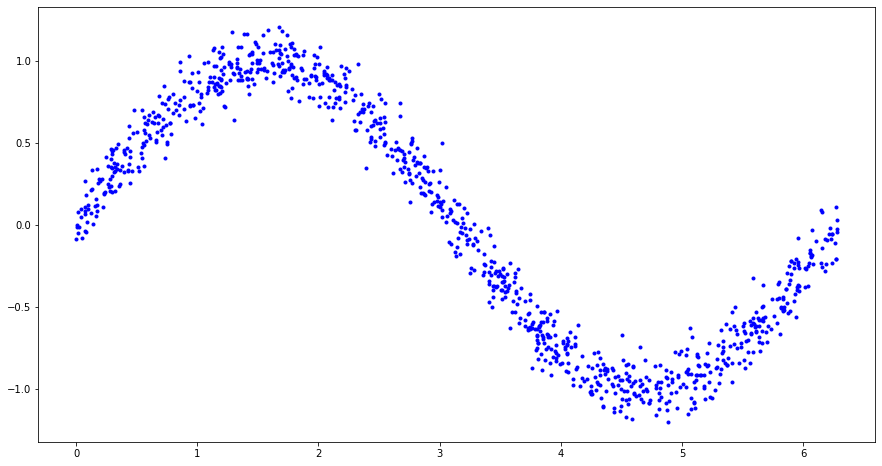

In [3]:
# Add a small random number to each y value
y_values += 0.1 * np.random.randn(*y_values.shape)

fig, axes = plt.subplots(figsize=(15,8))
axes.plot(x_values, y_values, 'b.')

### Splitting the Data

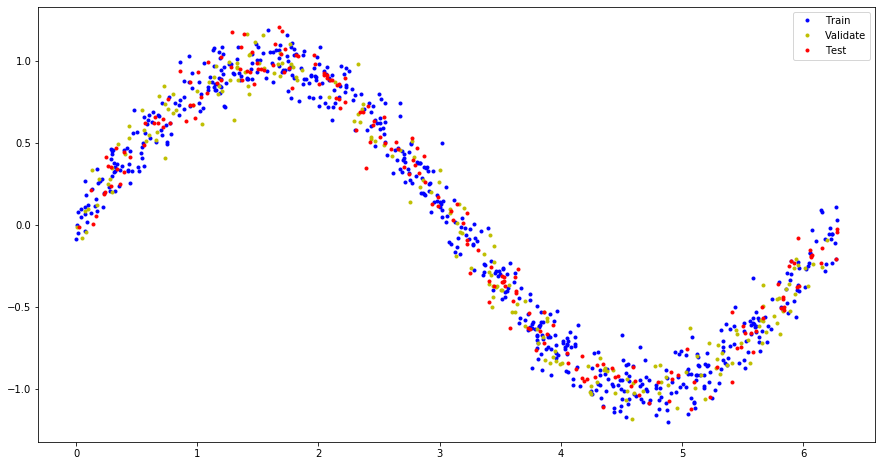

In [4]:
# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
x_train, x_validate, x_test = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_validate, y_test = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])


fig, axes = plt.subplots(figsize=(15,8))
axes.plot(x_train, y_train, 'b.', label="Train")
axes.plot(x_validate, y_validate, 'y.', label="Validate")
axes.plot(x_test, y_test, 'r.', label="Test")
axes.legend()

### Defining a Basic Model

In our problem we have one numeric input and we want to make one numeric prediction and we know that this type of problem is called a regression problem.

In [5]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(16, activation='relu', input_shape=(1,)))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

# Compile the model using a standard optimizer and loss function for regression
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                32        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


We create a `Sequential` model using Keras, which is a high-level neural networks API capable of running on top of TensorFlow, which means a model where each layer of neurons is stacked on top of the next.

Then we define two **layers**:
* The first layer, with a **single input and 16 neurons**, which is a `Dense` (fully connected) layer.
* The second layer has a **16 neurons** and may help the network learn more complex representations
* The third layer has a **single neuron** and it is our output

### Training our Model and Training Metrics

In [6]:
history = model.fit(x_train, y_train, epochs=600, batch_size=16, validation_data=(x_validate, y_validate))

Train on 600 samples, validate on 200 samples
Epoch 1/600
600/600 [==============================] - 2s 4ms/sample - loss: 0.4635 - mae: 0.6046 - val_loss: 0.3781 - val_mae: 0.5251
Epoch 2/600
600/600 [==============================] - 0s 172us/sample - loss: 0.3866 - mae: 0.5400 - val_loss: 0.3253 - val_mae: 0.4853
Epoch 3/600
600/600 [==============================] - 0s 100us/sample - loss: 0.3342 - mae: 0.5019 - val_loss: 0.2692 - val_mae: 0.4405
Epoch 4/600
600/600 [==============================] - 0s 92us/sample - loss: 0.2839 - mae: 0.4606 - val_loss: 0.2282 - val_mae: 0.4086
Epoch 5/600
600/600 [==============================] - 0s 102us/sample - loss: 0.2437 - mae: 0.4267 - val_loss: 0.1936 - val_mae: 0.3812
Epoch 6/600
600/600 [==============================] - 0s 93us/sample - loss: 0.2097 - mae: 0.3966 - val_loss: 0.1675 - val_mae: 0.3560
Epoch 7/600
600/600 [==============================] - 0s 110us/sample - loss: 0.1813 - mae: 0.3676 - val_loss: 0.1440 - val_mae: 0.3296

600/600 [==============================] - 0s 98us/sample - loss: 0.0226 - mae: 0.1117 - val_loss: 0.0172 - val_mae: 0.1015
Epoch 120/600
600/600 [==============================] - 0s 125us/sample - loss: 0.0219 - mae: 0.1110 - val_loss: 0.0222 - val_mae: 0.1226
Epoch 121/600
600/600 [==============================] - 0s 105us/sample - loss: 0.0216 - mae: 0.1105 - val_loss: 0.0191 - val_mae: 0.1088
Epoch 122/600
600/600 [==============================] - 0s 95us/sample - loss: 0.0208 - mae: 0.1090 - val_loss: 0.0182 - val_mae: 0.1079
Epoch 123/600
600/600 [==============================] - 0s 98us/sample - loss: 0.0212 - mae: 0.1092 - val_loss: 0.0168 - val_mae: 0.1028
Epoch 124/600
600/600 [==============================] - 0s 88us/sample - loss: 0.0209 - mae: 0.1084 - val_loss: 0.0162 - val_mae: 0.1004
Epoch 125/600
600/600 [==============================] - 0s 93us/sample - loss: 0.0199 - mae: 0.1072 - val_loss: 0.0170 - val_mae: 0.1001
Epoch 126/600
600/600 [=======================

600/600 [==============================] - 0s 97us/sample - loss: 0.0120 - mae: 0.0872 - val_loss: 0.0123 - val_mae: 0.0883
Epoch 238/600
600/600 [==============================] - 0s 105us/sample - loss: 0.0123 - mae: 0.0883 - val_loss: 0.0123 - val_mae: 0.0884
Epoch 239/600
600/600 [==============================] - 0s 98us/sample - loss: 0.0121 - mae: 0.0879 - val_loss: 0.0132 - val_mae: 0.0928
Epoch 240/600
600/600 [==============================] - 0s 97us/sample - loss: 0.0120 - mae: 0.0866 - val_loss: 0.0120 - val_mae: 0.0869
Epoch 241/600
600/600 [==============================] - ETA: 0s - loss: 0.0041 - mae: 0.053 - 0s 92us/sample - loss: 0.0122 - mae: 0.0874 - val_loss: 0.0113 - val_mae: 0.0840
Epoch 242/600
600/600 [==============================] - 0s 92us/sample - loss: 0.0118 - mae: 0.0869 - val_loss: 0.0144 - val_mae: 0.0942
Epoch 243/600
600/600 [==============================] - 0s 92us/sample - loss: 0.0122 - mae: 0.0878 - val_loss: 0.0123 - val_mae: 0.0875
Epoch 244

600/600 [==============================] - 0s 95us/sample - loss: 0.0116 - mae: 0.0866 - val_loss: 0.0190 - val_mae: 0.1134
Epoch 356/600
600/600 [==============================] - 0s 92us/sample - loss: 0.0120 - mae: 0.0889 - val_loss: 0.0123 - val_mae: 0.0900
Epoch 357/600
600/600 [==============================] - 0s 92us/sample - loss: 0.0114 - mae: 0.0858 - val_loss: 0.0136 - val_mae: 0.0928
Epoch 358/600
600/600 [==============================] - 0s 93us/sample - loss: 0.0120 - mae: 0.0870 - val_loss: 0.0128 - val_mae: 0.0892
Epoch 359/600
600/600 [==============================] - 0s 90us/sample - loss: 0.0117 - mae: 0.0864 - val_loss: 0.0130 - val_mae: 0.0923
Epoch 360/600
600/600 [==============================] - 0s 98us/sample - loss: 0.0116 - mae: 0.0858 - val_loss: 0.0151 - val_mae: 0.1005
Epoch 361/600
600/600 [==============================] - 0s 94us/sample - loss: 0.0116 - mae: 0.0868 - val_loss: 0.0136 - val_mae: 0.0934
Epoch 362/600
600/600 [=========================

600/600 [==============================] - 0s 92us/sample - loss: 0.0120 - mae: 0.0882 - val_loss: 0.0142 - val_mae: 0.0966
Epoch 474/600
600/600 [==============================] - 0s 88us/sample - loss: 0.0118 - mae: 0.0881 - val_loss: 0.0130 - val_mae: 0.0921
Epoch 475/600
600/600 [==============================] - 0s 93us/sample - loss: 0.0118 - mae: 0.0874 - val_loss: 0.0116 - val_mae: 0.0842
Epoch 476/600
600/600 [==============================] - 0s 92us/sample - loss: 0.0121 - mae: 0.0880 - val_loss: 0.0129 - val_mae: 0.0925
Epoch 477/600
600/600 [==============================] - 0s 92us/sample - loss: 0.0117 - mae: 0.0865 - val_loss: 0.0134 - val_mae: 0.0912
Epoch 478/600
600/600 [==============================] - 0s 97us/sample - loss: 0.0119 - mae: 0.0873 - val_loss: 0.0121 - val_mae: 0.0883
Epoch 479/600
600/600 [==============================] - 0s 93us/sample - loss: 0.0117 - mae: 0.0854 - val_loss: 0.0119 - val_mae: 0.0873
Epoch 480/600
600/600 [=========================

600/600 [==============================] - 0s 95us/sample - loss: 0.0119 - mae: 0.0873 - val_loss: 0.0136 - val_mae: 0.0938
Epoch 592/600
600/600 [==============================] - 0s 98us/sample - loss: 0.0116 - mae: 0.0854 - val_loss: 0.0114 - val_mae: 0.0844
Epoch 593/600
600/600 [==============================] - 0s 97us/sample - loss: 0.0114 - mae: 0.0855 - val_loss: 0.0149 - val_mae: 0.0994
Epoch 594/600
600/600 [==============================] - 0s 98us/sample - loss: 0.0117 - mae: 0.0870 - val_loss: 0.0145 - val_mae: 0.0987
Epoch 595/600
600/600 [==============================] - 0s 95us/sample - loss: 0.0116 - mae: 0.0867 - val_loss: 0.0142 - val_mae: 0.0971
Epoch 596/600
600/600 [==============================] - 0s 108us/sample - loss: 0.0115 - mae: 0.0853 - val_loss: 0.0120 - val_mae: 0.0866
Epoch 597/600
600/600 [==============================] - 0s 98us/sample - loss: 0.0115 - mae: 0.0850 - val_loss: 0.0158 - val_mae: 0.0991
Epoch 598/600
600/600 [========================

### Graphing the history

The `history` object contains an attribute, `history.history`, which is a dictionary recording metrics values during training and validation. We use this to collect the data we’re going to plot.

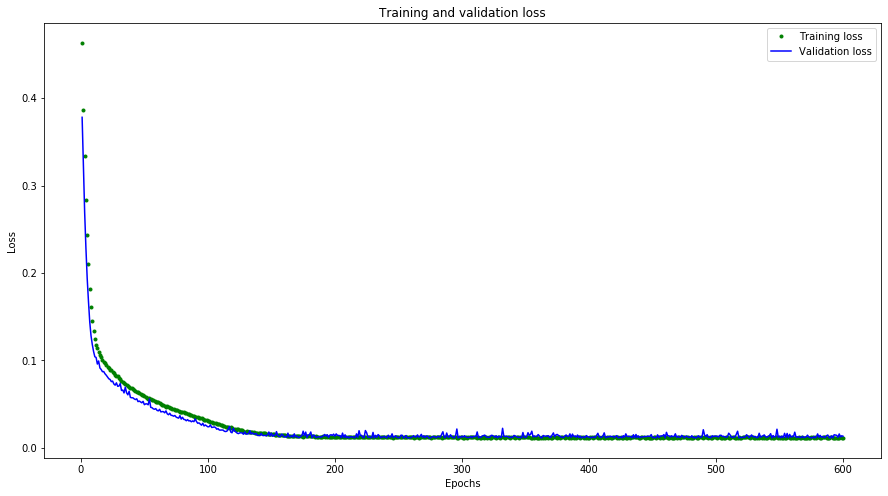

In [7]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

fig, axes = plt.subplots(figsize=(15,8))
axes.plot(epochs, loss, 'g.', label='Training loss')
axes.plot(epochs, val_loss, 'b', label='Validation loss')
axes.set_xlabel('Epochs')
axes.set_ylabel('Loss')
axes.set_title('Training and validation loss')
axes.legend();

We can see that the amount of loss rapidly decreases over the first 50-80 epochs, before flattening out.

Lets skip the first 50 epochs in the graph to make it more easy to read.

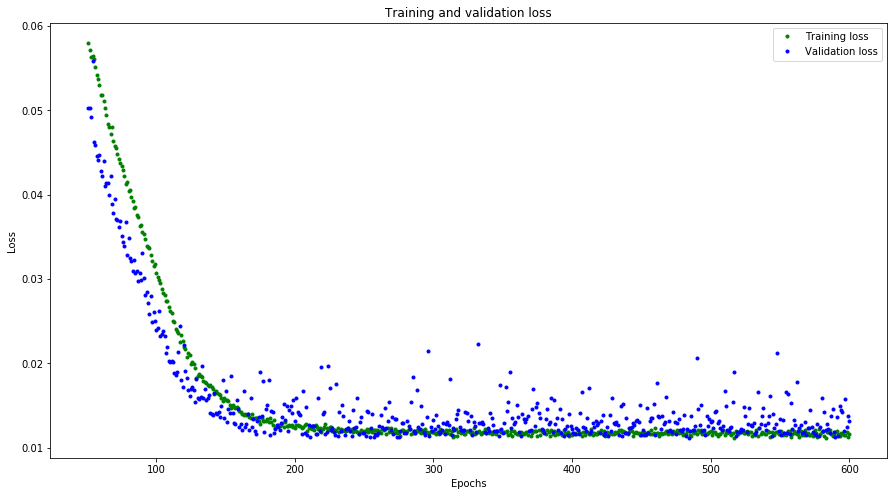

In [8]:
SKIP = 50

fig, axes = plt.subplots(figsize=(15,8))
axes.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
axes.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
axes.set_xlabel('Epochs')
axes.set_ylabel('Loss')
axes.set_title('Training and validation loss')
axes.legend();

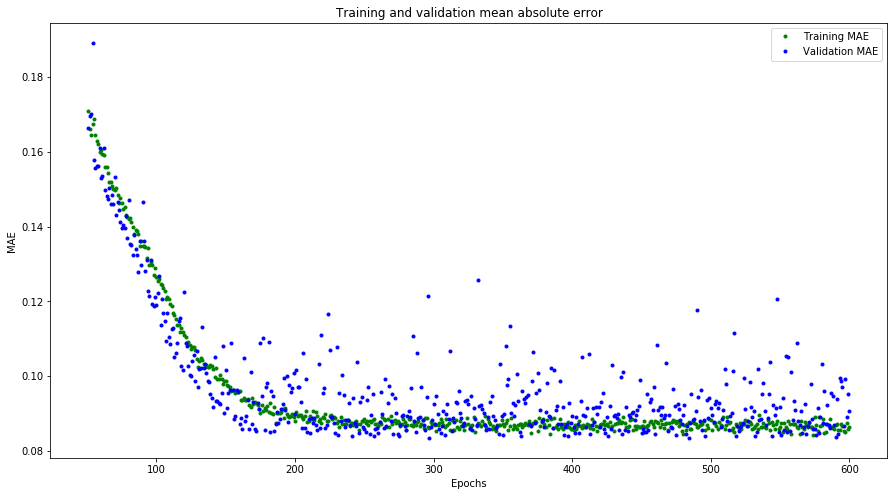

In [9]:
# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
mae = history.history['mae']
val_mae = history.history['val_mae']

fig, axes = plt.subplots(figsize=(15,8))
axes.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
axes.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
axes.set_xlabel('Epochs')
axes.set_ylabel('MAE')
axes.set_title('Training and validation mean absolute error')
axes.legend();

### Testing

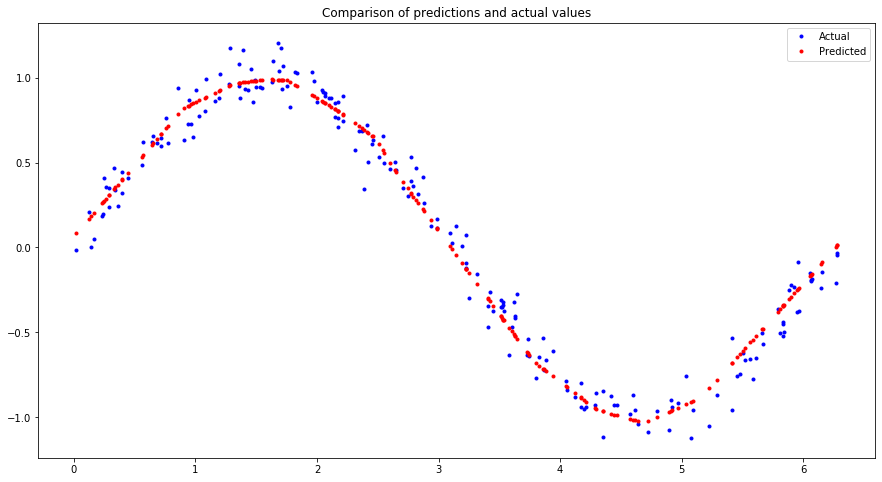

In [18]:
# Calculate and print the loss on our test dataset
loss = model.evaluate(x_test, y_test,verbose=0)
# Make predictions based on our test dataset
predictions = model.predict(x_test);

fig, axes = plt.subplots(figsize=(15,8))
axes.plot(x_test, y_test, 'b.', label='Actual')
axes.plot(x_test, predictions, 'r.', label='Predicted')
axes.set_title('Comparison of predictions and actual values')
axes.legend();

### Converting the Model for TensorFlow Lite

TensorFlow Lite is a set of tools for running TensorFlow models on "edge devices", meaning everything from mobile phones down to microcontroller boards.

It as having two main components:
* The **TensorFlow Lite Converter**, which converts TensorFlow models into a special, space-efficient format for use on memory-constrained devices, and can apply optimizations that further reduce the model size and make it run faster on small devices.

* The **TensorFlow Lite Interpreter**, which runs an appropriately converted TensorFlow Lite model using the most efficient operations for a given device


Before using our model with TensorFlow Lite, we’ll need to convert it and we will use the TensorFlow Lite Converter’s Python API to do this.

It will take our Keras model and write it to disk in the form of a FlatBuffer, which is a special file format designed to be **space-efficient**.

Furthermore the TensorFlow Lite Converter can also apply **optimizations to the model**, such as reducing the size of the model, the time it takes to run, or both. However, this can come **at the cost of a reduction in accuracy**, but the reduction is often small enough that it’s worthwhile.


One of the most useful optimizations is **quantization**.

By default, the weights and biases in a model **are stored as 32-bit floating point numbers**, however quantization allows you to reduce the precision of these numbers so that they **fit into 8-bit integers**.

This optimazation often results in minimal loss in accuracy and this means that when deploying to low-memory devices, it is nearly always worthwhile.


We will convert the model two times one with optimazations enabled and one with optimazations disabled.

In [11]:
# Convert the model to the TensorFlow Lite format without quantization and save it to the disk
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("sine_model.tflite", "wb").write(tflite_model)


# Convert the model to the TensorFlow Lite format with quantization
# Indicate that we want to perform the default optimizations, which includes quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]



# Define a generator function that provides our test data's x values
# as a representative dataset, and tell the converter to use it
def representative_dataset_generator():
    for value in x_test:
        # Each scalar value must be inside of a 2D array that is wrapped in a list
        yield [np.array(value, dtype=np.float32, ndmin=2)]
    
    
    
converter.representative_dataset = representative_dataset_generator
tflite_model = converter.convert()
open("sine_model_quantized.tflite", "wb").write(tflite_model)

2488

The function `representative_dataset_generator` is required to create a quantized model that runs as efficiently as possible, because the converter needs a set of numbers that **represent the full range of input values** that the model was trained on.

### Comparing the TensorFlow Lite models with the original model


We will compare the TensorFlow Lite models with our original model to prove that the models maintain the accurecy.

However these model must run on the TensorFlow Lite interpreter which is more complicated to use than the Keras API.

With TensorFlow Lite, we’ll have to do the following:
 1. Instantiate an `Interpreter` object
 2. Call some methods that allocate memory for the model
 3. Write the input to the input tensor
 4. Invoke the model
 5. Read the output from the output tensor

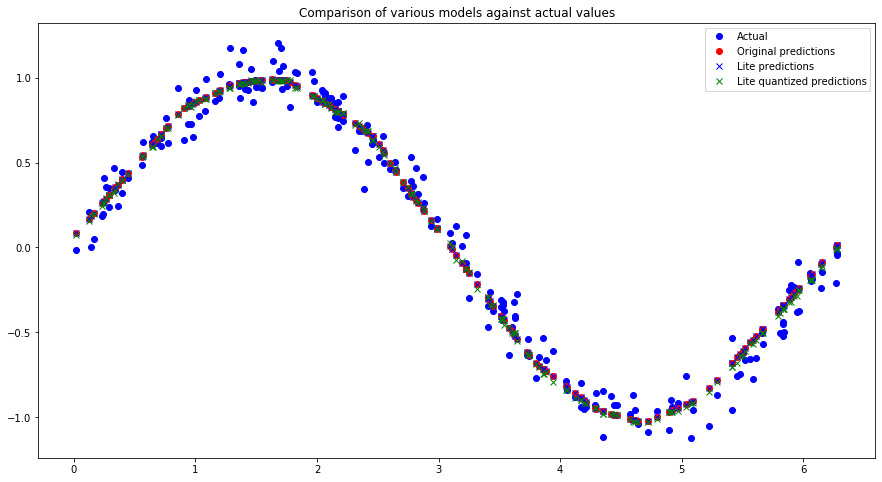

In [12]:
# Instantiate an interpreter for each model
sine_model = tf.lite.Interpreter('sine_model.tflite')
sine_model_quantized = tf.lite.Interpreter('sine_model_quantized.tflite')

# Allocate memory for each model
sine_model.allocate_tensors()
sine_model_quantized.allocate_tensors()

# Get indexes of the input and output tensors
sine_model_input_index = sine_model.get_input_details()[0]["index"]
sine_model_output_index = sine_model.get_output_details()[0]["index"]
sine_model_quantized_input_index = sine_model_quantized.get_input_details()[0]["index"]
sine_model_quantized_output_index = sine_model_quantized.get_output_details()[0]["index"]

# Create arrays to store the results
sine_model_predictions = []
sine_model_quantized_predictions = []

# Run each model's interpreter for each value and store the results in arrays
for x_value in x_test:
    # Create a 2D tensor wrapping the current x value
    x_value_tensor = tf.convert_to_tensor([[x_value]], dtype=np.float32)
    # Write the value to the input tensor
    sine_model.set_tensor(sine_model_input_index, x_value_tensor)
    # Run inference
    sine_model.invoke()
    # Read the prediction from the output tensor
    sine_model_predictions.append(sine_model.get_tensor(sine_model_output_index)[0])
    # Do the same for the quantized model
    sine_model_quantized.set_tensor(sine_model_quantized_input_index, x_value_tensor)
    sine_model_quantized.invoke()
    sine_model_quantized_predictions.append(sine_model_quantized.get_tensor(sine_model_quantized_output_index)[0])


# See how they line up with the data
fig, axes = plt.subplots(figsize=(15,8))
axes.plot(x_test, y_test, 'bo', label='Actual')
axes.plot(x_test, predictions, 'ro', label='Original predictions')
axes.plot(x_test, sine_model_predictions, 'bx', label='Lite predictions')
axes.plot(x_test, sine_model_quantized_predictions, 'gx', label='Lite quantized predictions')
axes.set_title('Comparison of various models against actual values')
axes.legend()

### Size comparison of the two models

In [13]:
basic_model_size = os.path.getsize("sine_model.tflite")
print("Basic model is %d bytes" % basic_model_size)
quantized_model_size = os.path.getsize("sine_model_quantized.tflite")
print("Quantized model is %d bytes" % quantized_model_size)
difference = basic_model_size - quantized_model_size
print("Difference is %d bytes" % difference)

Basic model is 2696 bytes
Quantized model is 2488 bytes
Difference is 208 bytes


We can see that there is a small difference of 228 bytes, which is very usefull in a memory constrained eviroment, but it’s only a minor reduction in size.

This is because the model in adittion to the weights and biases also contains all the logic and the architecture of our DNN, known as its **computation graph**. For truly tiny models, this can add up to more size than the model’s weights, meaning quantization has little effect.

More complex models have many more weights, meaning the space saving from quantization will be much higher and can even approach 4x for most sophisticated models.

### Converting to a C File

The final step in preparing our model for use with TensorFlow Lite for Microcontrollers is to **convert it into a C source file** that can be included in our application.


So far we’ve been using TensorFlow Lite’s Python API and we’ve been able to use the Interpreter constructor to load our model files from disk.

However, most microcontrollers don’t have a filesystem or implementing a file system would be wasteful given our limited space.

Instead we provide the model in a C source file that can be included in our binary and loaded directly into memory.

Fortunately, there’s a convenient Unix tool named `xxd` that is able to convert a given file into a the required format with the follownig command:

`xxd -i sine_model_quantized.tflite > sine_model_quantized.cc`

Unfortunately, there is no tool for Windows but we can do it in python with the following code.

In [14]:
def generate_tf_lite_c(file, print_output=False,per_line=16):
    
    with open(file, 'rb') as f:
        content = f.read()
        
    length = len(content)
    
    filename = os.path.splitext(os.path.basename(file))[0]
    output = "unsigned char {0}[] = {{".format(filename)
        
    for i,byte in enumerate(content):
        if i%per_line==0:
            output+="\n\t"
            new_line=False
        output+="0x{:02x}, ".format(byte)
        
        
    output=output[:-2]
    output+="\n};\n"
    output+="unsigned int {0}_len = 2512;\n".format(filename)
    
    if print_output:
        print(output)
        
    with open("{0}.c".format(filename), 'wt') as f:
        f.write(output)
        
    print("File {0}.c written".format(filename))

In [15]:
filename = 'sine_model_quantized.tflite'
generate_tf_lite_c(filename, print_output=True, per_line=12)

unsigned char sine_model_quantized[] = {
	0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x12, 0x00, 
	0x1c, 0x00, 0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00, 0x14, 0x00, 
	0x00, 0x00, 0x18, 0x00, 0x12, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00, 
	0x48, 0x09, 0x00, 0x00, 0xac, 0x02, 0x00, 0x00, 0x94, 0x02, 0x00, 0x00, 
	0x3c, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 
	0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x04, 0x00, 0x08, 0x00, 
	0x08, 0x00, 0x00, 0x00, 0x08, 0x00, 0x00, 0x00, 0x0b, 0x00, 0x00, 0x00, 
	0x13, 0x00, 0x00, 0x00, 0x6d, 0x69, 0x6e, 0x5f, 0x72, 0x75, 0x6e, 0x74, 
	0x69, 0x6d, 0x65, 0x5f, 0x76, 0x65, 0x72, 0x73, 0x69, 0x6f, 0x6e, 0x00, 
	0x0c, 0x00, 0x00, 0x00, 0x4c, 0x02, 0x00, 0x00, 0x44, 0x02, 0x00, 0x00, 
	0x34, 0x01, 0x00, 0x00, 0x24, 0x01, 0x00, 0x00, 0x18, 0x01, 0x00, 0x00, 
	0x10, 0x01, 0x00, 0x00, 0xf0, 0x00, 0x00, 0x00, 0xa0, 0x00, 0x00, 0x00, 
	0x50, 0x00, 0x00, 0x00, 0x30, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00

## TinyML: Building an Application


A model is just a part of a ML application. In order for our model to be useful we have to use additional code to provide the necessary environment for it to run.

![app_arch_ch5](./images/app_arch_ch5.png)


The program we will present consists a continuous loop which feeds an x value into the model, runs infererence, and uses the result to produce some sort of (visible) output.


We will create a file named `main_functions.cc` and the first thing we must do is to include some necessary files.


```c
#include "tensorflow/lite/micro/examples/hello_world/constants.h"
```
```c
#include "tensorflow/lite/micro/examples/hello_world/output_handler.h"
```
Device specific headers containing various constants and a way to output.

```c
#include "tensorflow/lite/micro/examples/hello_world/sine_model_data.h"

```  
The sine model we trained, converted, and transformed into C++.

```c
#include "tensorflow/lite/micro/kernels/all_ops_resolver.h"
```
A class that allows the interpreter to load the operations used by our model.

```c 
#include "tensorflow/lite/micro/micro_error_reporter.h"
```
A class that can log errors and output to help with debugging.

```c
#include "tensorflow/lite/micro/micro_interpreter.h"
```
The TensorFlow Lite for Microcontrollers interpreter, which will run our model.

```c
#include "tensorflow/lite/schema/schema_generated.h"
```
The schema that defines the structure of TensorFlow Lite FlatBuffer data, used to make sense of the model data in `sine_model_data.h`.

```c
#include "tensorflow/lite/version.h"
```
The current version number of the schema, so we can check that the model was defined with a compatible version.

Next we must define the global variables we we use.

```c
namespace {
    
tflite::ErrorReporter* error_reporter = nullptr;
const tflite::Model* model = nullptr;
tflite::MicroInterpreter* interpreter = nullptr;
TfLiteTensor* input = nullptr;
TfLiteTensor* output = nullptr;
int inference_count = 0;

constexpr int kTensorArenaSize = 2 * 1024;
uint8_t tensor_arena[kTensorArenaSize];
    
}
```

These variables are defined inside a `namespace` so they are only visible in this file.

The variable `kTensorArenaSize` defines the memory we allocate for our model.

Different model architectures have different sizes and numbers of input, output, and intermediate tensors, so it’s hard to tell how much memory we’ll need. The number doesn’t have to be exact—we can reserve more memory than we need—but since microcontrollers have limited RAM, we should keep it as small as possible so there’s space for the rest of our program.


The variable `inference_count` is used to keep track of how many inferences our program has performed.


Then we delcare a function named `setup()` which is called when only the program first runs (powering up the MCU or restarting, etc.).


```c
void setup() {

    // Set up logging.
    static tflite::MicroErrorReporter micro_error_reporter;
    error_reporter = &micro_error_reporter;

    // Map the model into a usable data structure. This doesn't involve any
    // copying or parsing, it's a very lightweight operation.
    model = tflite::GetModel(g_sine_model_data);
    
    if (model->version() != TFLITE_SCHEMA_VERSION) {
        error_reporter->Report(
            "Model provided is schema version %d not equal "
            "to supported version %d.",
            model->version(), TFLITE_SCHEMA_VERSION);
        return;
    }

    // This pulls in all the operation implementations we need.
    static tflite::ops::micro::AllOpsResolver resolver;

    // Build an interpreter to run the model with.
    static tflite::MicroInterpreter static_interpreter(
      model, resolver, tensor_arena, kTensorArenaSize, error_reporter);
    interpreter = &static_interpreter;

    // Allocate memory from the tensor_arena for the model's tensors.
    TfLiteStatus allocate_status = interpreter->AllocateTensors();
    if (allocate_status != kTfLiteOk) {
        error_reporter->Report("AllocateTensors() failed");
        return;
    }
    
    // Obtain pointers to the model's input and output tensors.
    input = interpreter->input(0);
    output = interpreter->output(0);
    
    // Keep track of how many inferences we have performed.
    inference_count = 0;
}
    
```


The `MicroErrorReporter` class provides a mechanism for logging debug information during inference.

We’ll be calling it to print debug information, and the TensorFlow Lite for Microcontrollers interpreter will use it to print any errors it encounters.

`MicroErrorReporter` is a subclass of the `ErrorReporter` class which provides a template for how this sort of debug logging mechanism should work in TensorFlow Lite and ii is specifically designed for microcontrollers.


Next we map our model to `model` using `GetModel()`.

The variable `model` is a `Model` type variable which is a struct and it holds our model’s data and allows us to query information about it.

We must also check if the version of our model and TensorFlow Lite version match to avoid any problems.

The `resolver` is used to access all avalable mathematical and graph operations needed to transform input into output and are availabe to TensorFlow Lite for Microcontrollers.


After building the interpreter and allocationg memmory for our model we obtain a pointer for the models input and output using the interpreter’s `input()` and `output()` method.


Depending on the number of input and output tensors our model has, we need to provide an index to those methods. 

The input and output pointers is a `TfLiteTensor` type which is a struct that contains many usefull information like the dimensions(`dims`) or the type (`type`) of the tensor.

It also contains a fieled named `data` whose type is `TfLitePtrUnion`. 

Since a given tensor can contain one of many different types of data (for example, floating point numbers, integers, or booleans), a union is the perfect type to help us store it.

```c
// A union of pointers that points to memory for a given tensor.
typedef union {
    int32_t* i32;
    int64_t* i64;
    float* f;
    TfLiteFloat16* f16;
    char* raw;
    const char* raw_const;
    uint8_t* uint8;
    bool* b;
    int16_t* i16;
    TfLiteComplex64* c64;
    int8_t* int8;
} TfLitePtrUnion;
```

We can see that there are a many members, each representing a certain type.

When we call `interpreter.AllocateTensors()` the appropriate pointer is set to point at the block of memory that was allocated for the tensor to store its data.

Since each tensor has a specific data type, only the pointer for the corresponding type will be set.


After the `setup()` fuction our infrastructure is set up and ready to go.

The next step is to define a function named `loop()` which will define is our application logic.

The code in this function will run repeatedly like an infinite loop, thus the name.

```c
void loop() {
    // Calculate an x value to feed into the model. We compare the current
    // inference_count to the number of inferences per cycle to determine
    // our position within the range of possible x values the model was
    // trained on, and use this to calculate a value.
    float position = 
        static_cast<float>(inference_count) / static_cast<float>(kInferencesPerCycle);
    float x_val = position * kXrange;

    // Place our calculated x value in the model's input tensor
    input->data.f[0] = x_val;

    // Run inference, and report any error
    TfLiteStatus invoke_status = interpreter->Invoke();
    if (invoke_status != kTfLiteOk) {
        error_reporter->Report("Invoke failed on x_val: %f\n", static_cast<double>(x_val));
        return;
    }

    // Read the predicted y value from the model's output tensor
    float y_val = output->data.f[0];

    // Output the results. A custom HandleOutput function can be implemented
    // for each supported hardware target.
    HandleOutput(error_reporter, x_val, y_val);

    // Increment the inference_counter, and reset it if we have reached
    // the total number per cycle
    inference_count += 1;
    if (inference_count >= kInferencesPerCycle) inference_count = 0;
}


```
The first two lines of code just divide inference_count by `kInferencesPerCycle`, to obtain our current “position” within the range.

The next line multiplies that value by `kXrange`and the result, `x_val`, is the value we’ll be passing into our model.

* `kXrange` represents the range of x values our model was trained on which is from 0 to (2 * Pi).

* `kInferencesPerCycle`  determines the number of inferences to perform across the range of x values defined above.

    Since each inference takes time, the higher this number, the more time it will take to run through the entire range. The value of this constant can be tuned so that one full cycle takes a desired amount of time. Since different devices take different amounts of time to perform inference, this value should be defined per-device.




In next part of our we write our x value to the model’s input tensor, run inference, and then grab the result from the output tensor.

And finnaly we output uor value using `HandleOutput()`.

The `HandleOutput()` can be overriden and provide the desirable output, for example display the values in a LCD or vary the brightness of a LED.


The specific function names may differ from MCU one architecture to another but the main idea is still the same.

We have one "setup" function and one "loop" function.

## TinyML: Deploying to Microcontrollers

Finally, the last step is to actually **deploy our code** to a device.

After using the appropriacte compiler (avr-gcc, arm-gcc, etc) a .hex or a .bin file is generated and with the help of the right tool (avrdude, etc) we can flash the binary to the device.

Depending on the code we have written we may need to connect various other peripherals to our MCU board like senosrs, LEDs, displays, ADCs/DACs or speakers for our ML project.



### Optimizations

We already have seen one optimization called **quantization**.

**Quantization** refers to the process of reducing the number of bits that represent a number.

Most if not all deep learning frameworks use 32-bit floating point (**FP32**) as the predominant numerical format.

However, the desire for reduced bandwidth and compute requirements of deep learning models has driven research into using lower-precision numerical formats.

It has been extensively demonstrated that weights and activations can be represented using 8-bit integers (**INT8**) **without incurring significant loss in accuracy**. 

The more obvious benefit from quantization is **significantly reduced bandwidth and storage**.

For instance, using INT8 for weights and activations consumes 4x less overall bandwidth compared to FP32.

Additionally integer compute is **faster** than floating point compute. It is also much more **area and energy efficient**:


| INT8 Operation | Energy Saving vs FP32 | Area Saving vs FP32 |
| -------------- |---------------------- | ------------------- |
| Add            | 30x                   | 116x                |
| Multiply       | 18.5x                 | 27x                 |


Other optimizations are more specific to the hardware and the project we are working on.

For example on Cortex-M devices we can use **Single instruction, Multiple data** (SIMD) instructions, to operate on 2 x 16-bit values or 4 x 8-bit values at the same time within a 32-bit register, which can often provide a big speedup.